DNA Sequence Prediction

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

# Nucleotides
NUCLEOTIDES = ['A', 'T', 'C', 'G']
NUCLEOTIDE_TO_IDX = {n: i for i, n in enumerate(NUCLEOTIDES)}


In [8]:

# Generate Synthetic DNA Sequence Data (or use actual datasets)
def generate_dna_sequence(length=1000):
    return ''.join(random.choices(NUCLEOTIDES, k=length))

# Dataset class for DNA sequence prediction
class DNADataset(Dataset):
    def __init__(self, sequence, seq_len=10):
        self.sequence = sequence
        self.seq_len = seq_len

    def __len__(self):
        return len(self.sequence) - self.seq_len

    def __getitem__(self, idx):
        input_seq = self.sequence[idx:idx + self.seq_len]
        target_nuc = self.sequence[idx + self.seq_len]
        input_encoded = torch.tensor([NUCLEOTIDE_TO_IDX[n] for n in input_seq], dtype=torch.long)
        target_encoded = torch.tensor(NUCLEOTIDE_TO_IDX[target_nuc], dtype=torch.long)
        return input_encoded, target_encoded

# Create a synthetic dataset
dna_sequence = generate_dna_sequence(length=10000)  # Adjust length as needed
train_dataset = DNADataset(dna_sequence, seq_len=5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# LSTM Model with less than 1024 parameters
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SimpleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])  # Take last time-step output
        return output

# Model parameters
embedding_dim = 5  # Embedding size for nucleotides
hidden_dim = 8     # LSTM hidden dimension (small to keep parameters < 1024)
vocab_size = len(NUCLEOTIDES)  # 4 (A, T, C, G)

model = SimpleLSTM(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

# Ensure the model has less than 1024 parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")
assert total_params < 1024, "Model has more than 1024 trainable parameters"

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 30
for epoch in range(epochs):
    total_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

print("Training complete!")


Total trainable parameters: 536
Epoch 1, Loss: 1.3904
Epoch 2, Loss: 1.3868
Epoch 3, Loss: 1.3863
Epoch 4, Loss: 1.3866
Epoch 5, Loss: 1.3863
Epoch 6, Loss: 1.3860
Epoch 7, Loss: 1.3864
Epoch 8, Loss: 1.3859
Epoch 9, Loss: 1.3862
Epoch 10, Loss: 1.3860
Epoch 11, Loss: 1.3860
Epoch 12, Loss: 1.3860
Epoch 13, Loss: 1.3859
Epoch 14, Loss: 1.3857
Epoch 15, Loss: 1.3857
Epoch 16, Loss: 1.3855
Epoch 17, Loss: 1.3853
Epoch 18, Loss: 1.3856
Epoch 19, Loss: 1.3856
Epoch 20, Loss: 1.3854
Epoch 21, Loss: 1.3853
Epoch 22, Loss: 1.3853
Epoch 23, Loss: 1.3853
Epoch 24, Loss: 1.3854
Epoch 25, Loss: 1.3851
Epoch 26, Loss: 1.3852
Epoch 27, Loss: 1.3849
Epoch 28, Loss: 1.3851
Epoch 29, Loss: 1.3850
Epoch 30, Loss: 1.3849
Training complete!


Airline Passenger Prediction

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

# Downloading Airline Passenger Dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(url, usecols=[1])  # Only use the 'Passengers' column


In [27]:

# Preprocess the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.values.reshape(-1, 1))


In [28]:

# Create a dataset for sequence prediction (windowed approach)
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, index):
        x = self.data[index:index + self.sequence_length]
        y = self.data[index + self.sequence_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

sequence_length = 40  # Number of previous time steps to use for prediction
dataset = TimeSeriesDataset(data_normalized, sequence_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [29]:

# LSTM Model with less than 1024 parameters
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])  # Output from the last time step
        return output


In [36]:

# Model parameters
input_size = 1  # Since each time step is a scalar value (passengers count)
hidden_dim = 1280  # Small hidden size to keep the parameter count low
model = SimpleLSTM(input_size=input_size, hidden_dim=hidden_dim)

# Check total parameters (ensure it's below 1024)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")
# assert total_params < 1024, "Model has more than 1024 trainable parameters"

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Total trainable parameters: 6570241


In [37]:
# Training the model
epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        # Remove the unsqueeze operation
        # inputs = inputs.unsqueeze(-1)  # This line is no longer needed

        # Reshape inputs to (batch_size, seq_len, input_size)
        inputs = inputs.view(-1, sequence_length, input_size)  # Ensure inputs are 3D

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.6f}')

print("Training complete!")


Epoch 10, Loss: 0.050711
Epoch 20, Loss: 0.032127
Epoch 30, Loss: 0.020458
Epoch 40, Loss: 0.013313
Epoch 50, Loss: 0.005851
Epoch 60, Loss: 0.009856
Epoch 70, Loss: 0.006663
Epoch 80, Loss: 0.004448
Epoch 90, Loss: 0.005726
Epoch 100, Loss: 0.004628
Training complete!


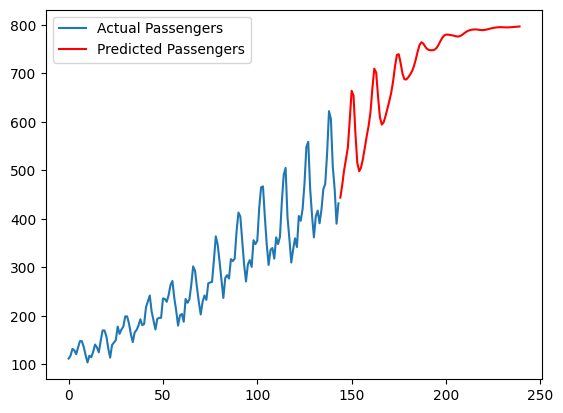

In [38]:

# Making predictions
def predict_future(model, data, sequence_length, num_steps):
    model.eval()
    predictions = []
    input_seq = torch.tensor(data[-sequence_length:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    
    with torch.no_grad():
        for _ in range(num_steps):
            pred = model(input_seq)
            predictions.append(pred.item())
            input_seq = torch.cat((input_seq[:, 1:, :], pred.unsqueeze(0)), dim=1)

    return predictions

# Predict the next 12 months (1 year)
num_steps = 96
predictions = predict_future(model, data_normalized.flatten(), sequence_length, num_steps)

# Inverse scale the predictions
predicted_passengers = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plotting the results
plt.plot(data.values, label='Actual Passengers')
plt.plot(range(len(data), len(data) + num_steps), predicted_passengers, label='Predicted Passengers', color='red')
plt.legend()
plt.show()


Predicting the Gaussian Problem statement


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Step 1: Generate Synthetic Data
n_samples = 10000
X, y = make_blobs(n_samples=n_samples, centers=2, cluster_std=1.5, random_state=42)


In [27]:

# Standardize the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)


In [28]:

# Step 2: Define the MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 16)  # Input layer (2 features) to hidden layer (16 neurons)
        self.fc2 = nn.Linear(16, 2)   # Hidden layer (16 neurons) to output layer (2 classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = self.fc2(x)               # No activation for output layer
        return x

# Create the model
model = MLP()


In [29]:

# Step 3: Train the Model
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Optimizer

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients
    outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.2668
Epoch [20/100], Loss: 0.0769
Epoch [30/100], Loss: 0.0250
Epoch [40/100], Loss: 0.0123
Epoch [50/100], Loss: 0.0083
Epoch [60/100], Loss: 0.0066
Epoch [70/100], Loss: 0.0056
Epoch [80/100], Loss: 0.0050
Epoch [90/100], Loss: 0.0045
Epoch [100/100], Loss: 0.0041


Accuracy: 99.98%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[1988    1]
 [   0 2011]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1989
           1       1.00      1.00      1.00      2011

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



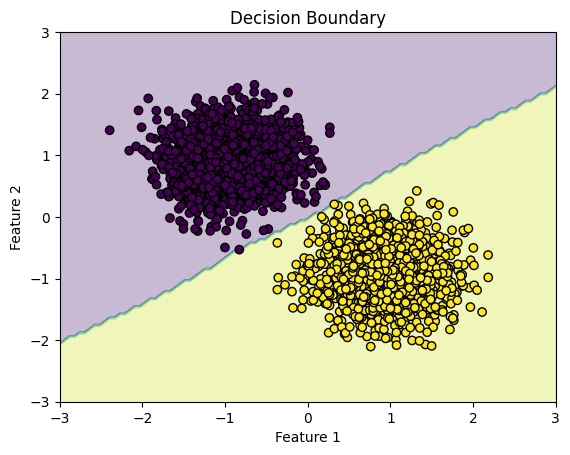

In [30]:

# Step 4: Evaluate the Model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test_tensor, predicted)
    precision = precision_score(y_test_tensor, predicted)
    recall = recall_score(y_test_tensor, predicted)
    f1 = f1_score(y_test_tensor, predicted)
    cm = confusion_matrix(y_test_tensor, predicted)
    
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')
    print(cm)
    print('\nClassification Report:')
    print(classification_report(y_test_tensor, predicted))

# Plotting the decision boundary
xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
with torch.no_grad():
    Z = model(grid)
    _, Z = torch.max(Z.data, 1)
Z = Z.numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k')
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
